This notebook is related to a series of other notebooks

- [Data preprocessing](https://www.kaggle.com/code/db0boy/lending-club-loan-data-cleared-preparation) 

- Adding new features and splitting data

- [Constructing interpreted logistic regression](https://www.kaggle.com/code/db0boy/credit-scoring-interpretable-model)

- [Building uninterpreted models](https://www.kaggle.com/code/db0boy/credit-scoring-uninterpretable-models)

Also, all notebooks are linked to [this repository](https://github.com/boyfws/Predicting-default)

# Imports

In [1]:
import pandas as pd
import numpy as np
from typing import Union, Optional
import warnings
import os
import random

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [4]:
X = pd.read_csv("/kaggle/input/lending-club-loan-data-cleared/X.csv")
y = pd.read_csv("/kaggle/input/lending-club-loan-data-cleared/target.csv")["y"]

# Removing features

In [5]:
SHARE = 0.01
mask = (
    (X["princ_rec"] <= X["funded_amnt"] * (1 + SHARE)) 
    & (X["funded_amnt"] * (1 - SHARE) <=  X["princ_rec"])
)

mask.mean()

0.48298197409567856

In [6]:
y[mask].mean()

0.00019643722862874234

As we can see, some of the loans have already been paid off and the share of defaults in them is statistically insignificant, but deleting these observations will lead to the fact that in some years we will have no observations for which there was no default, which will hinder model building, so the logical step would be to delete ``princ_rec``, as this feature may lead to data leakage. Same for ```paym_rec_for_tot_amnt_fund```and ```remaining_princ_for_tot_amnt_fund```

In [7]:
X = X.drop(["princ_rec", "paym_rec_for_tot_amnt_fund", "remaining_princ_for_tot_amnt_fund"], axis=1)

Under the terms of my project work, it is application scoring that we are doing, so we will remove some of the variables that are not actually available at the time of credit applications 

In [8]:
X = X.drop(
    [
        "interest_rate",
        "monthly_payment",
        "interest_rec",
        "late_fees_rec",
    ],
    axis=1
)

We should also remove the ``grade`` column, as we do not want to use the company's predictions in our model 

In [9]:
X = X.drop("grade", axis=1)

# Feature engineering

In [10]:
X.columns

Index(['funded_amnt', 'emp_title', 'emp_length', 'home_ownership_status',
       'annual_income', 'verification_status', 'loan_purpose', 'addr_state',
       'dept_paym_income_ratio', 'num_30+_delinq_in_2yrs', 'num_inq_in_6mths',
       'mths_since_last_delinq', 'num_open_credit_lines',
       'num_derogatory_pub_rec', 'total_credit_revolving_bal',
       'used_credit_share', 'tot_num_credit_lines', 'initial_list_status',
       'num_open_trades_in_6mths', 'num_installment_acc_op_in_12mths',
       'num_installment_acc_op_in_24mths',
       'mths_since_last_installment_acc_op', 'num_rev_trades_op_in_12mths',
       'num_rev_trades_op_in_24mths', 'max_bal_owed', 'bal_to_cred_lim',
       'num_inq', 'num_inq_in_12mths', 'mths_since_recent_bankcard_delinq',
       'mths_since_recent_revol_delinq', 'disbursement_method',
       'loan_term_months', 'issue_date_month', 'issue_date_year',
       'region_code', 'earliest_cr_line_month', 'earliest_cr_line_year'],
      dtype='object')

In [11]:
%%writefile feature_adder.py

import pandas as pd
import numpy as np 

def add_new_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()

    X["num_inc_in_fund_amnt"] = X["annual_income"] / X["funded_amnt"]
    X["max_bal_owed_per_income"] = X["max_bal_owed"] / X["annual_income"]
    X["total_credit_revolving_bal_per_income"] = X["total_credit_revolving_bal"] / X["annual_income"]
    X["closed_credit_lines_share"] = (X["tot_num_credit_lines"] - X["num_open_credit_lines"]) / X["tot_num_credit_lines"]
    
    X["earliest_cr_line_full"] = X["earliest_cr_line_month"] + X["earliest_cr_line_year"].astype(str)
    
    X["cost_of_expr"] = X["annual_income"] / X["emp_length"].replace(
                                                        {
                                                            '10+ years': 10,
                                                            '6 years': 6,
                                                            "4 years": 4,
                                                            "< 1 year": np.NaN,
                                                            '2 years': 2,
                                                            "9 years": 9,
                                                            '5 years': 5, 
                                                            '3 years': 3,
                                                            '7 years': 7, 
                                                            '1 year': 1,
                                                            '8 years': 8
                                                        }
                                                    )
    month_to_num = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    
    earliest_cr_line_month_num = X['earliest_cr_line_month'].map(month_to_num)
    issue_date_month_num = X["issue_date_month"].map(month_to_num)
    
    X['earliest_cr_line_month_sin'] = np.sin(2 * np.pi * earliest_cr_line_month_num / 12)
    X['earliest_cr_line_month_cos'] = np.cos(2 * np.pi * earliest_cr_line_month_num / 12)
    
    X['issue_date_month_num_sin'] = np.sin(2 * np.pi * issue_date_month_num / 12)
    X['issue_date_month_num_cos'] = np.cos(2 * np.pi * issue_date_month_num / 12)

    return X


Writing feature_adder.py


In [12]:
from feature_adder import add_new_features

X = add_new_features(X)

In [13]:
X.select_dtypes(include='number').corr()[
    ["cost_of_expr", 
     "closed_credit_lines_share", 
     "total_credit_revolving_bal_per_income", 
     "max_bal_owed_per_income",
     "num_inc_in_fund_amnt"
    ]
]

,cost_of_expr,closed_credit_lines_share,total_credit_revolving_bal_per_income,max_bal_owed_per_income,num_inc_in_fund_amnt
funded_amnt,0.146293,0.084183,0.146495,0.075318,-0.243269
annual_income,0.555786,0.051542,-0.038853,-0.078660,0.508472
dept_paym_income_ratio,-0.111666,-0.025956,0.348955,0.269980,-0.087576
num_30+_delinq_in_2yrs,0.019835,0.106828,-0.073009,-0.092239,0.025783
num_inq_in_6mths,0.016032,0.026671,-0.047552,-0.099929,0.021178
mths_since_last_delinq,-0.024569,-0.004044,0.018693,0.044390,-0.018909
num_open_credit_lines,0.058403,-0.200290,0.179045,-0.041374,0.001021
num_derogatory_pub_rec,-0.011323,0.029829,-0.109157,-0.098371,0.011230
total_credit_revolving_bal,0.122343,0.017715,0.702568,0.252209,0.006819
used_credit_share,0.006205,0.048616,0.310361,0.307234,-0.014572


# Data split 

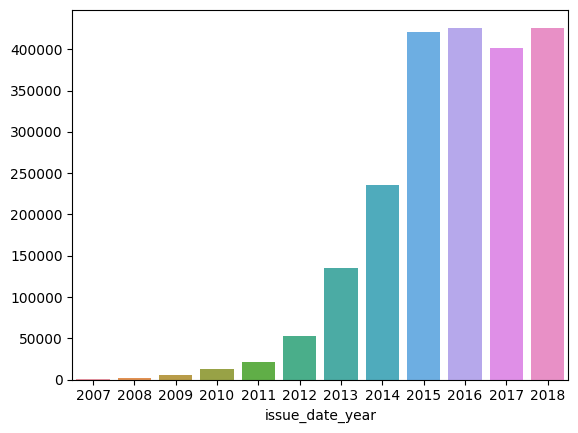

In [14]:
counter = X["issue_date_year"].value_counts()

sns.barplot(x=counter.index, y=counter.values);

<Axes: title={'center': 'Percentage of defaults in each year'}>

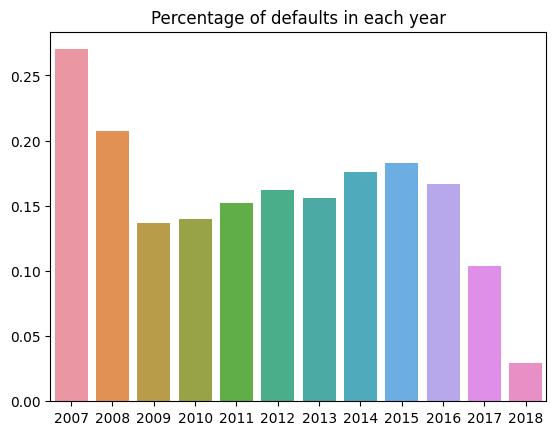

In [15]:
year = sorted(X["issue_date_year"].unique())
def_share = [None for i in range(len(year))]


for i, el in enumerate(year):
    mask = X["issue_date_year"] == el
    def_share[i] = y[mask].mean()


plt.title("Percentage of defaults in each year")
sns.barplot(x=year, y=def_share)

We split the data by year to test our models in the real conditions of data shift availability 

In [16]:
test_mask = X["issue_date_year"] == 2017
val_mask = X["issue_date_year"] == 2018

X = X.drop(["issue_date_year"], axis=1)

X_train, X_test, X_val = X.loc[~(test_mask | val_mask)], X.loc[test_mask], X.loc[val_mask]
y_train, y_test, y_val = y.loc[~(test_mask | val_mask)], y.loc[test_mask], y.loc[val_mask]

In [17]:
X_train, X_test, X_val = (
    X_train.reset_index(drop=True), 
    X_test.reset_index(drop=True), 
    X_val.reset_index(drop=True)
)

In [18]:
print(f"Train share: {(X_train.shape[0] / X.shape[0]):.2f}")
print(f"Test share: {(X_test.shape[0] / X.shape[0]):.2f}")
print(f"Val share: {(X_val.shape[0] / X.shape[0]):.2f}")

Train share: 0.61
Test share: 0.19
Val share: 0.20


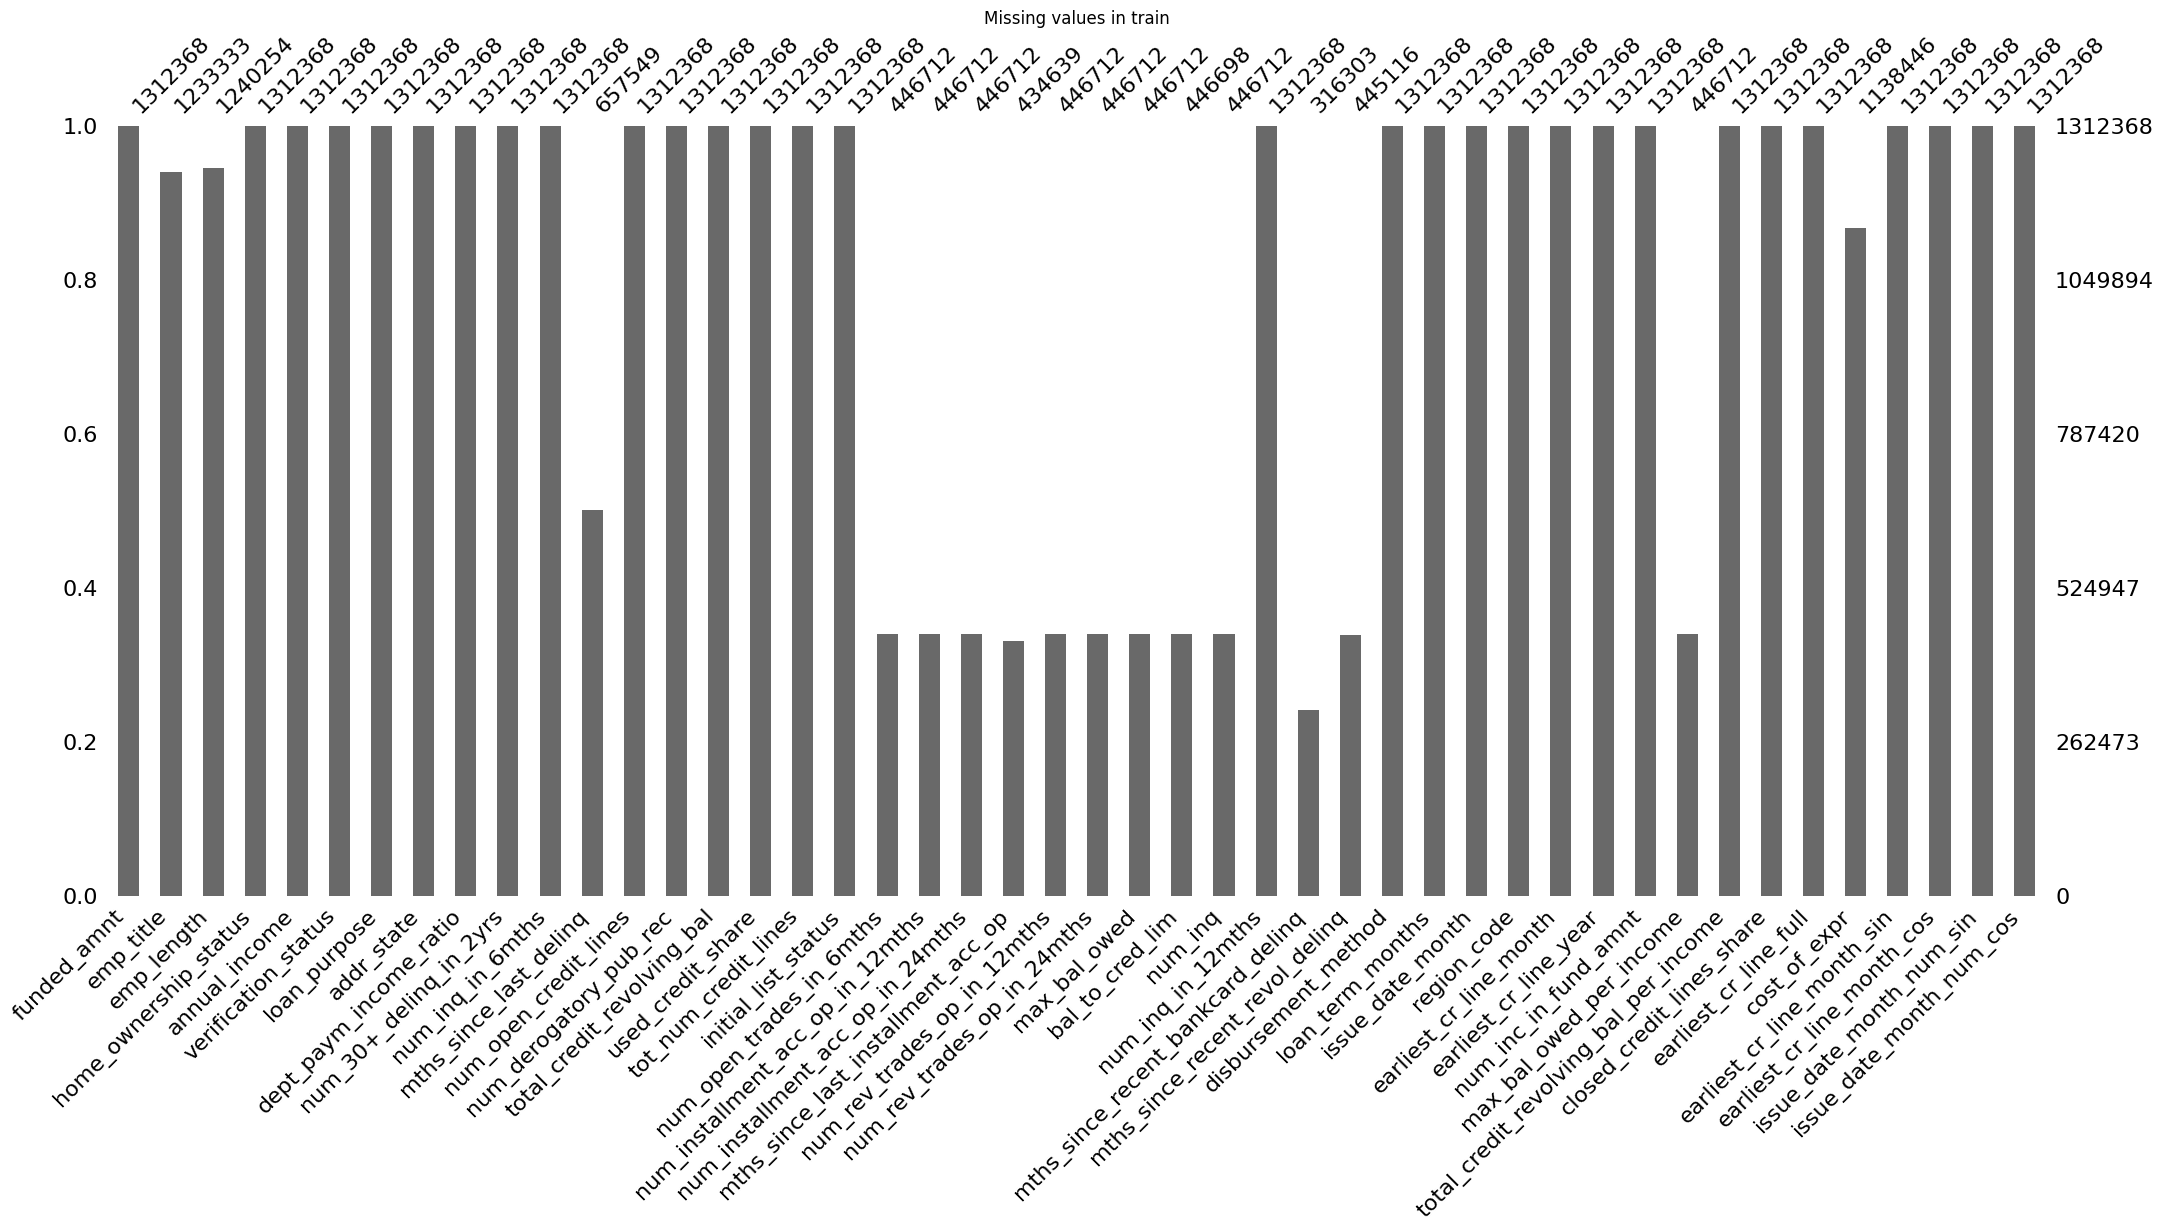

In [19]:
plt.title(f"Missing values in train")
msno.bar(X_train)
plt.show();

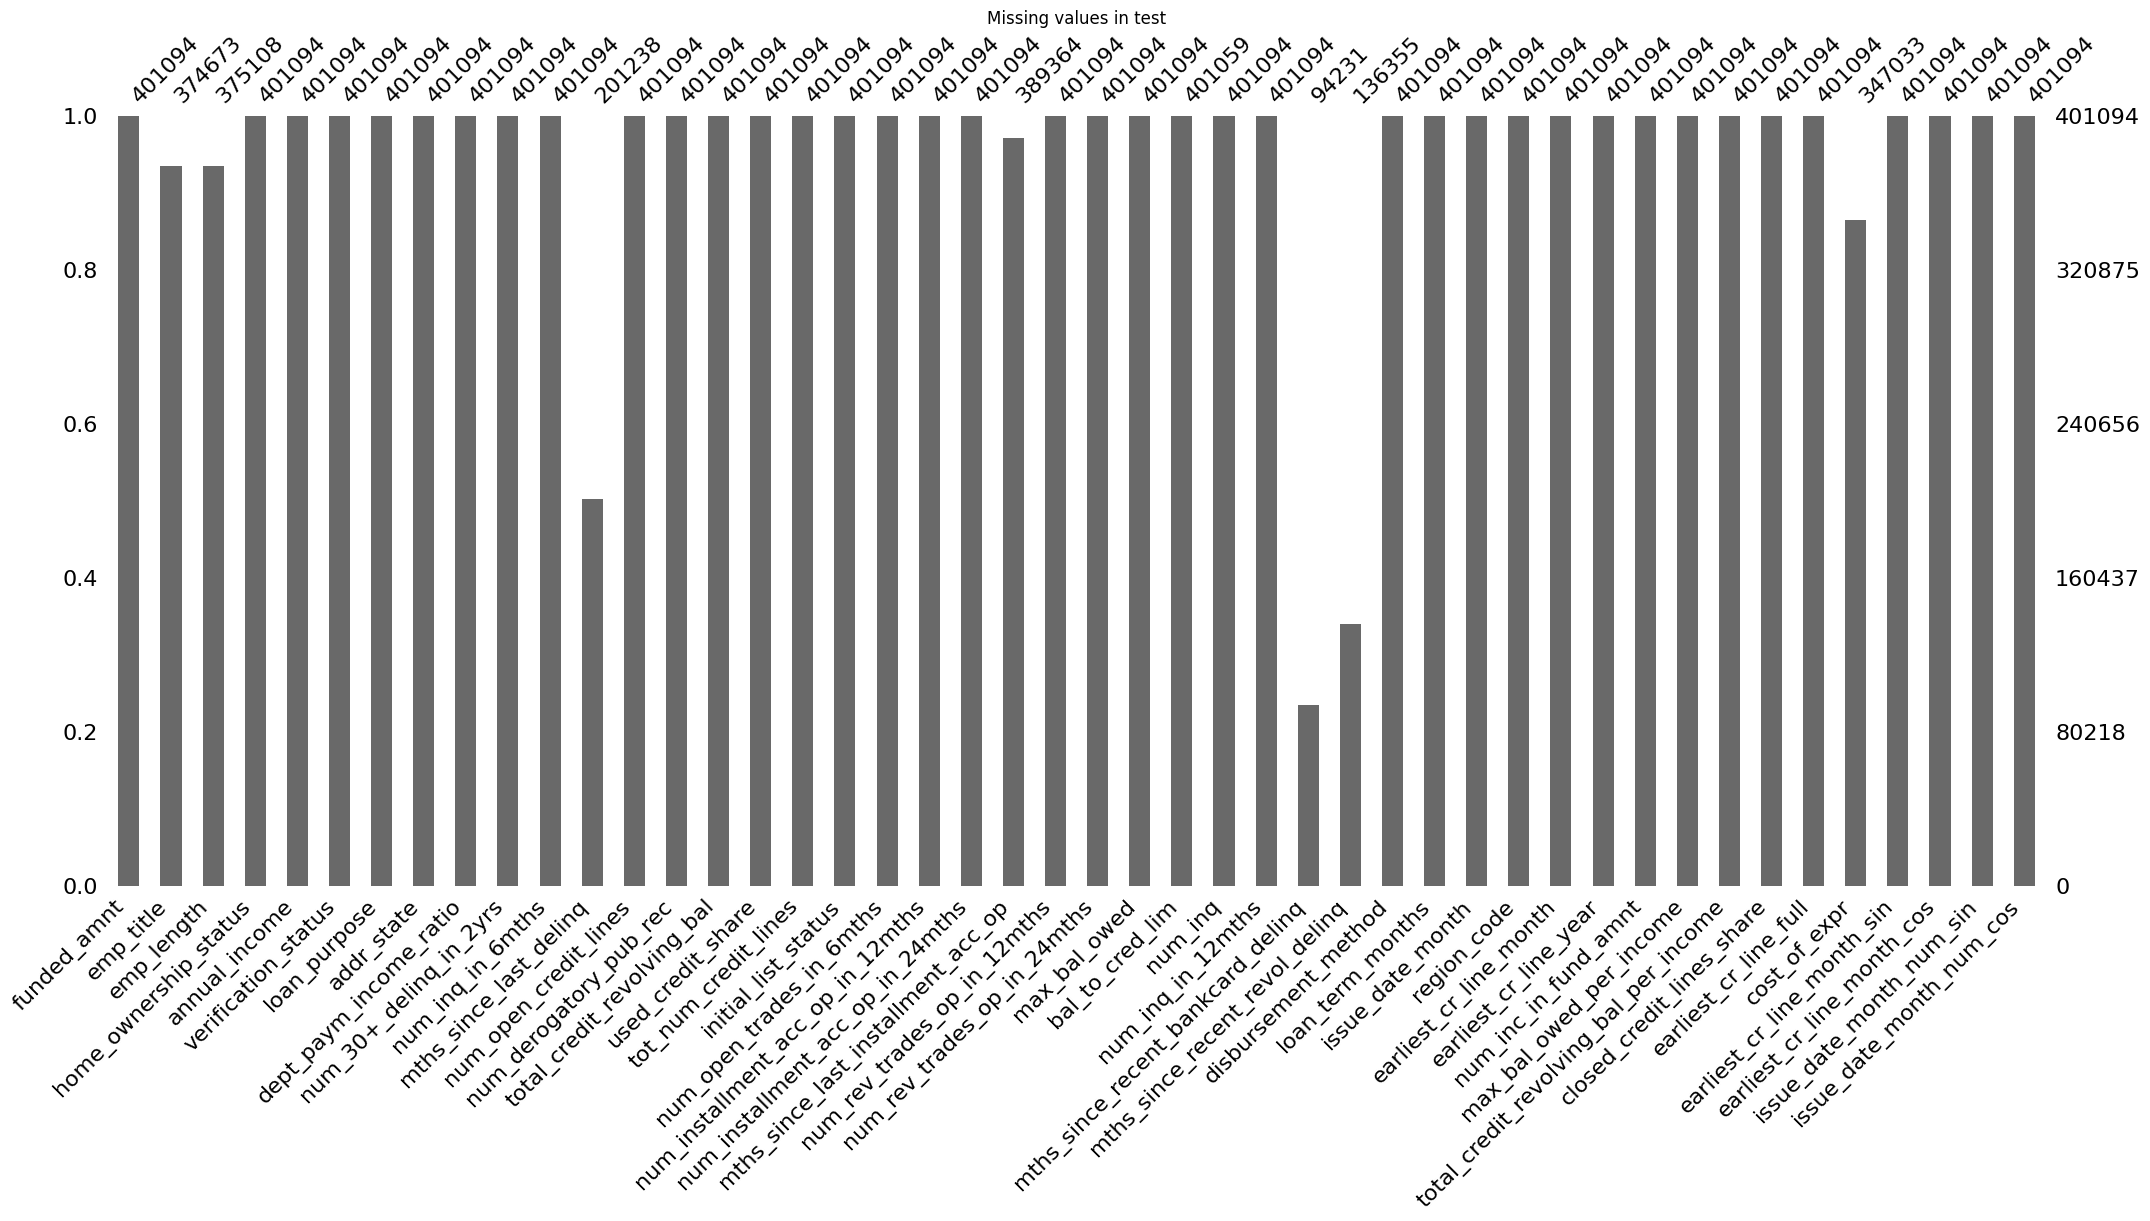

In [20]:
plt.title(f"Missing values in test")
msno.bar(X_test)
plt.show();

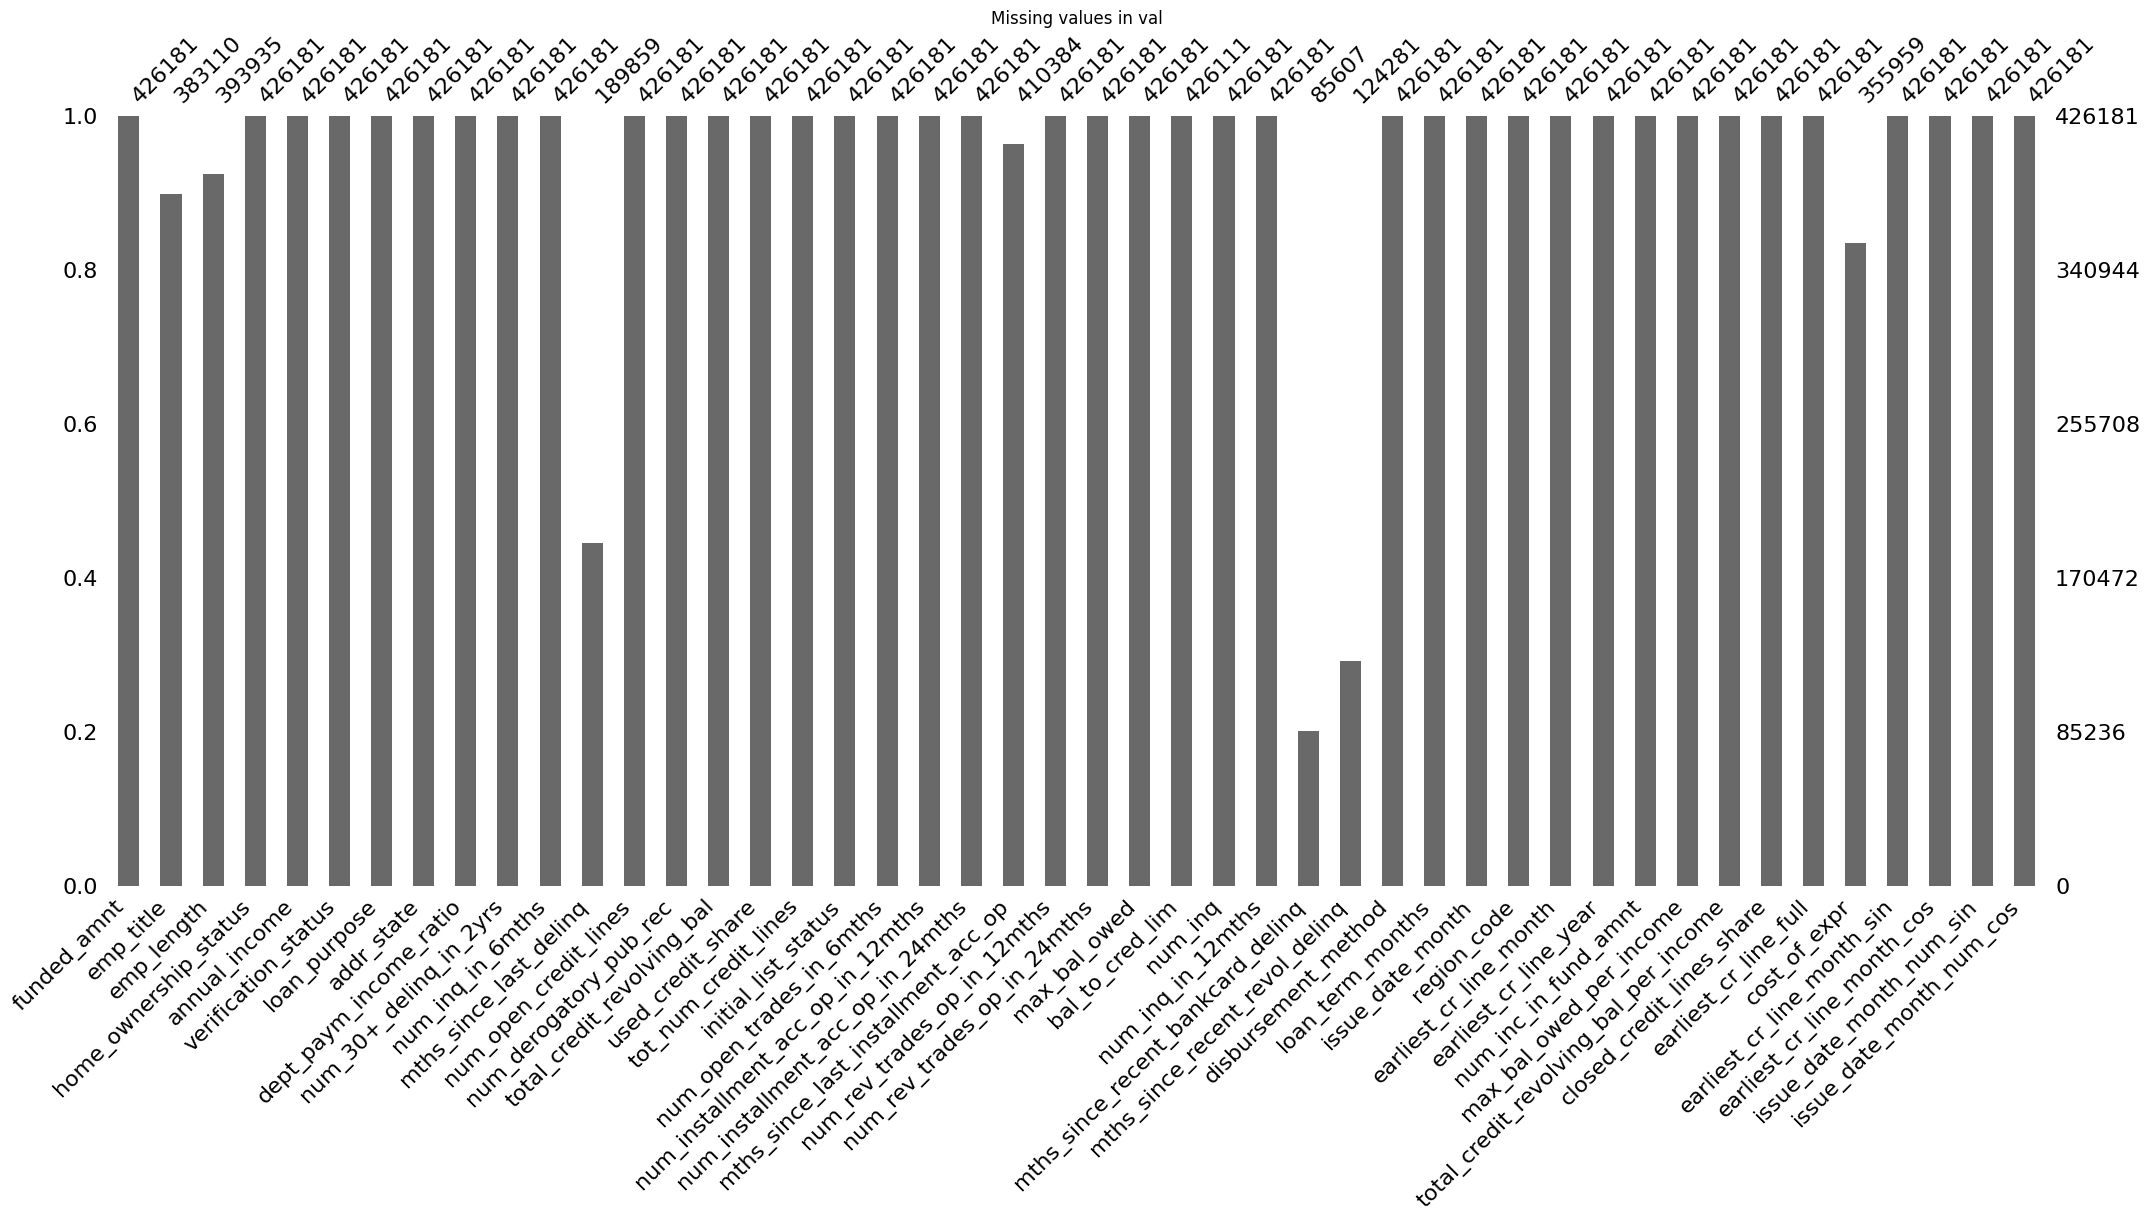

In [21]:
plt.title(f"Missing values in val")
msno.bar(X_val)
plt.show();

In [22]:
X_train.to_csv("X_train.csv", index=False) 
X_test.to_csv("X_test.csv", index=False)
X_val.to_csv("X_val.csv", index=False)

np.save("y_train.npy", y_train.to_numpy())
np.save("y_test.npy", y_test.to_numpy())
np.save("y_val.npy", y_val.to_numpy())